经验证：
* 1、test的时间顺序并不是全部都是时序的，排行榜是按时序排列后取前0.78为public，后0.22为private，所以以后的工作重心将落到train的后44%
* 2、测试集中私有部分从2018-07-24 09:00:00开始，有9173472条数据，包含全部的building_id
* 3、测试集中公共部分与私有部分对应的数据从2017-07-24 09:00:00开始，有9174900条数据，包含全部的building_id
* 4、重点为训练集中2017-07-24 09:00:00后的数据建模，有9003109条数据，占训练集0.445
* 5、为防止测试集中不评分的那部分不知道算不算在0.22里面，也为防止一定的过拟合，可以考虑重点关注2017-07月后的训练数据，占0.51
* 6、验证EDA1后，发现0-104号建筑5月20日前的大量为0的数据是有误的，训练集不应该对这部分数据进行过拟合，删除这部分数据训练对提高public评分很有帮助，遗憾的是，private并不包含这类数据
* 7、猜想某些大范围为0的数据都同0-104号一样是有误的，重点验证7月后的该种数据，测试是否能提高public

In [9]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)


py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input\ashrae-energy-prediction\building_metadata.csv
../input\ashrae-energy-prediction\sample_submission.csv
../input\ashrae-energy-prediction\test.csv
../input\ashrae-energy-prediction\test_weather.csv
../input\ashrae-energy-prediction\train.csv
../input\ashrae-energy-prediction\train_weather.csv
../input\ashrae-energy-prediction\weather_test.csv
../input\ashrae-energy-prediction\weather_train.csv


In [10]:
# 导入数据, 只有train 和 test
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv')
test = pd.read_csv('../input/ashrae-energy-prediction/test.csv')
building_df = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')

In [11]:
# 时间戳转换日期
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])

In [12]:
# 结合konstan的1.36的预测观察
sub_136 = pd.read_csv('../output/ashrae-baseline-lgbm/submission.csv')
test['meter_reading'] = sub_136.meter_reading.values
del sub_136

sub_test = pd.read_csv('../output/ashrae-baseline-lgbm-predict/submission.csv')
test['meter_reading_test'] = sub_test.meter_reading.values
del sub_test
gc.collect()

87

In [13]:
train['exception'] = 0

In [14]:
gc.collect()

40

In [15]:
# num = 0
# for i in range(1449):
#     meter_array = train[train.building_id == i].meter.unique()
#     if len(meter_array) == 3:
#         if (1 in meter_array) and (2 in meter_array) and (3 in meter_array):
#             num += 1
# print(num)

In [16]:
# 1413个建筑有0，498个建筑有1，324个建筑有2，145个建筑有3
# [0,1]有132个，[0,2]64，[0,3]21, [1,2]13
# [0,1,2]220, [0,1,3]111
# [0,1,2,3]13

In [17]:
test

,row_id,building_id,meter,timestamp,meter_reading,meter_reading_test
0,0,0,0,2017-01-01 00:00:00,0.726651,12.600851
1,1,1,0,2017-01-01 00:00:00,0.628281,12.685303
2,2,2,0,2017-01-01 00:00:00,0.000000,11.595356
3,3,3,0,2017-01-01 00:00:00,1.097136,61.798067
4,4,4,0,2017-01-01 00:00:00,1.271202,115.873078
...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,6.898671,9.489712
41697596,41697596,1445,0,2018-05-09 07:00:00,5.089137,5.364464
41697597,41697597,1446,0,2018-05-09 07:00:00,3.232176,3.221291
41697598,41697598,1447,0,2018-05-09 07:00:00,159.693070,100.577882


In [18]:
gc.collect()

20

In [19]:
# (0,0)到(104,0)从5月中旬才开始有读数, 其中有些在开始有读数之前有一些读数，不知什么情况
# 猜测该地区出现了大面积的电表故障或者大面积的电力故障，其中有极少建筑幸存或用于检修测试，所以有少量读数，5月中旬后修好才恢复该地区正常用电或读表

In [20]:
def plot_train_test(building_id, meter):
    plt.plot(train[(train.building_id == building_id) & (train.meter == meter)]['timestamp'], train[(train.building_id == building_id) & (train.meter == meter)]['meter_reading'])
    plt.figure(figsize=(12, 4))
    plt.plot(test[(test.building_id == building_id) & (test.meter == meter)]['timestamp'], test[(test.building_id == building_id) & (test.meter == meter)]['meter_reading'])
    plt.figure(figsize=(12, 4))
    plt.plot(test[(test.building_id == building_id) & (test.meter == meter)]['timestamp'], test[(test.building_id == building_id) & (test.meter == meter)]['meter_reading_test'])

In [21]:
building_df[building_df.site_id == 7].building_id.max()

803

In [22]:
building_df[building_df.building_id == 29]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
29,0,29,Education,113866,2006.0,NaN


In [23]:
building_df[building_df.building_id == 1393]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1393,15,1393,Entertainment/public assembly,151900,1990.0,NaN


In [24]:
building_df[(building_df.site_id == 13) & (building_df.primary_use == "Office")]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1069,13,1069,Office,20864,NaN,NaN
1071,13,1071,Office,10385,NaN,NaN
1073,13,1073,Office,194111,NaN,NaN
1074,13,1074,Office,89858,NaN,NaN
1075,13,1075,Office,72709,NaN,NaN
...,...,...,...,...,...,...
1211,13,1211,Office,94988,NaN,NaN
1214,13,1214,Office,195437,NaN,NaN
1216,13,1216,Office,15269,NaN,NaN
1219,13,1219,Office,91316,NaN,NaN


In [25]:
train[train.building_id == 1393].meter.unique()

array([0], dtype=int64)

In [26]:
train[(train.building_id == 532) & (train.timestamp > '2016-05-20 00:00:00')].meter_reading.value_counts()

1.40      58
1.08      35
1.41      35
1.09      33
1.36      25
          ..
49.17      1
56.69      1
80.89      1
117.22     1
58.50      1
Name: meter_reading, Length: 2927, dtype: int64

In [27]:
train[(train.building_id == 740) & (train.meter_reading != 0)]

,building_id,meter,timestamp,meter_reading,exception
888,740,0,2016-01-01 00:00:00,0.0002,0
3187,740,0,2016-01-01 01:00:00,0.0004,0
5482,740,0,2016-01-01 02:00:00,0.0004,0
7780,740,0,2016-01-01 03:00:00,0.0004,0
10075,740,0,2016-01-01 04:00:00,0.0004,0
...,...,...,...,...,...
20205199,740,0,2016-12-31 19:00:00,0.0004,0
20207562,740,0,2016-12-31 20:00:00,0.0004,0
20209927,740,0,2016-12-31 21:00:00,0.0004,0
20212293,740,0,2016-12-31 22:00:00,0.0004,0


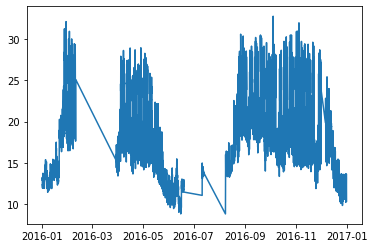

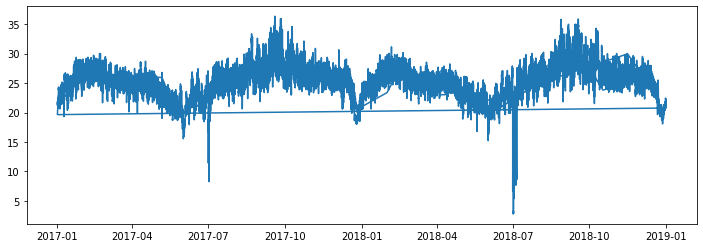

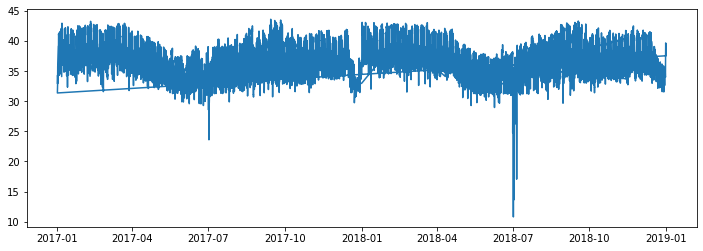

In [28]:
plot_train_test(1396, 0)

In [29]:
## 异常标记

train.loc[(train.building_id == 29) & (train.meter == 0) & (train.meter_reading < 500), 'exception'] = 1
train.loc[(train.building_id == 29) & (train.meter == 0) & (train.meter_reading >= 500), 'exception'] = -1

train.loc[(train.building_id == 53) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 53) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 106) & (train.meter == 0) & (train.meter_reading < 1), 'exception'] = 1
train.loc[(train.building_id == 106) & (train.meter == 0) & (train.meter_reading >= 1), 'exception'] = -1

train.loc[(train.building_id == 107) & (train.meter == 0) & (train.meter_reading <= 1), 'exception'] = 1
train.loc[(train.building_id == 107) & (train.meter == 0) & (train.meter_reading > 1), 'exception'] = -1

train.loc[(train.building_id == 112) & (train.meter == 0) & (train.meter_reading <= 1), 'exception'] = 1
train.loc[(train.building_id == 112) & (train.meter == 0) & (train.meter_reading > 1), 'exception'] = -1

train.loc[(train.building_id == 144) & (train.meter == 0) & (train.meter_reading <= 5), 'exception'] = 1
train.loc[(train.building_id == 144) & (train.meter == 0) & (train.meter_reading > 5), 'exception'] = -1

# 147也许不用这样做,可能对私有没有影响
train.loc[(train.building_id == 147) & (train.meter == 0) & (train.meter_reading <= 1), 'exception'] = 1
train.loc[(train.building_id == 147) & (train.meter == 0) & (train.meter_reading > 1), 'exception'] = -1

# 180有三个值出现过多, 也有小部分出现也比较多的相同值，以后再看是否处理
train.loc[(train.building_id == 180) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 180) & (train.meter == 0) & (train.meter_reading == 18.17), 'exception'] = 1
train.loc[(train.building_id == 180) & (train.meter == 0) & (train.meter_reading == 30.41), 'exception'] = 1
train.loc[(train.building_id == 180) & (train.meter == 0) & (train.meter_reading != 0) & (train.meter_reading != 18.17) & (train.meter_reading != 30.41), 'exception'] = -1

# 218也有很多重复值, 将前四作为异常
train.loc[(train.building_id == 218) & (train.meter == 0) & (train.meter_reading == 59.94), 'exception'] = 1
train.loc[(train.building_id == 218) & (train.meter == 0) & (train.meter_reading == 85.44), 'exception'] = 1
train.loc[(train.building_id == 218) & (train.meter == 0) & (train.meter_reading == 5.31), 'exception'] = 1
train.loc[(train.building_id == 218) & (train.meter == 0) & (train.meter_reading == 57.31), 'exception'] = 1
train.loc[(train.building_id == 218) & (train.meter == 0) & (train.meter_reading != 59.94) & (train.meter_reading != 85.44) & (train.meter_reading != 5.31) & (train.meter_reading != 57.31), 'exception'] = -1

train.loc[(train.building_id == 258) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 258) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

# 260也许很低的那部分全是异常，值得探究，暂且先把小于50的部分当作异常
train.loc[(train.building_id == 260) & (train.meter == 0) & (train.meter_reading < 50), 'exception'] = 1
train.loc[(train.building_id == 260) & (train.meter == 0) & (train.meter_reading >= 50), 'exception'] = -1

# 331是学校放假还是异常值得探究，先将小于200部分算作异常
train.loc[(train.building_id == 331) & (train.meter == 0) & (train.meter_reading <= 200), 'exception'] = 1
train.loc[(train.building_id == 331) & (train.meter == 0) & (train.meter_reading > 200), 'exception'] = -1

train.loc[(train.building_id == 604) & (train.meter == 0) & (train.meter_reading < 0.5), 'exception'] = 1
train.loc[(train.building_id == 604) & (train.meter == 0) & (train.meter_reading >= 0.5), 'exception'] = -1

train.loc[(train.building_id == 693) & (train.meter == 0) & (train.meter_reading < 20), 'exception'] = 1
train.loc[(train.building_id == 693) & (train.meter == 0) & (train.meter_reading >= 20), 'exception'] = -1

train.loc[(train.building_id == 723) & (train.meter == 0) & (train.meter_reading < 30), 'exception'] = 1
train.loc[(train.building_id == 723) & (train.meter == 0) & (train.meter_reading >= 30), 'exception'] = -1

# 740全是异常
train.loc[(train.building_id == 740) & (train.meter == 0) & (train.meter_reading < 30), 'exception'] = 1
# train.loc[(train.building_id == 740) & (train.meter == 0) & (train.meter_reading >= 30), 'exception'] = -1

train.loc[(train.building_id == 799) & (train.meter == 0) & (train.meter_reading < 10), 'exception'] = 1
train.loc[(train.building_id == 799) & (train.meter == 0) & (train.meter_reading >= 10), 'exception'] = -1

train.loc[(train.building_id == 802) & (train.meter == 0) & (train.meter_reading < 10), 'exception'] = 1
train.loc[(train.building_id == 802) & (train.meter == 0) & (train.meter_reading >= 10), 'exception'] = -1

train.loc[(train.building_id == 803) & (train.meter == 0) & (train.meter_reading < 100), 'exception'] = 1
train.loc[(train.building_id == 803) & (train.meter == 0) & (train.meter_reading >= 100), 'exception'] = -1

train.loc[(train.building_id == 815) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 815) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

# 853和845的异常居然一样，严重怀疑都有异常
train.loc[(train.building_id == 853) & (train.meter == 0) & (train.meter_reading < 0.05), 'exception'] = 1
train.loc[(train.building_id == 853) & (train.meter == 0) & (train.meter_reading >= 0.05), 'exception'] = -1

train.loc[(train.building_id == 857) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 857) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 864) & (train.meter == 0) & (train.meter_reading < 2), 'exception'] = 1
train.loc[(train.building_id == 864) & (train.meter == 0) & (train.meter_reading >= 2), 'exception'] = -1

train.loc[(train.building_id == 886) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 886) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

# 904对私有不影响
train.loc[(train.building_id == 904) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 904) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 954) & (train.meter == 0) & (train.meter_reading < 100), 'exception'] = 1
train.loc[(train.building_id == 954) & (train.meter == 0) & (train.meter_reading >= 100), 'exception'] = -1

# 994不知道是不是放假，但与周围比较，更像异常
train.loc[(train.building_id == 994) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 994) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

# 997对私有无影响
train.loc[(train.building_id == 994) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 994) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

# 1113对私有无影响
train.loc[(train.building_id == 1113) & (train.meter == 0) & (train.meter_reading < 5), 'exception'] = 1
train.loc[(train.building_id == 1113) & (train.meter == 0) & (train.meter_reading >= 5), 'exception'] = -1

# 对私有影响不大
train.loc[(train.building_id == 1169) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1169) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1199) & (train.meter == 0) & (train.meter_reading == 25.207), 'exception'] = 1
train.loc[(train.building_id == 1199) & (train.meter == 0) & (train.meter_reading != 25.207), 'exception'] = -1

train.loc[(train.building_id == 1221) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1221) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1223) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1223) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1225) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1225) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1226) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1226) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

# 1227也许可以全部数据标记为异常
train.loc[(train.building_id == 1227) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1227) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1233) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1233) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1234) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1234) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1241) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1241) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1250) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1250) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1255) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1255) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1264) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1264) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1272) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1272) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

for i in range(1275, 1281):
    train.loc[(train.building_id == i) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
    train.loc[(train.building_id == i) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1
    
train.loc[(train.building_id == 1283) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1283) & (train.meter == 0) & (train.meter_reading == 77.8316), 'exception'] = 1
train.loc[(train.building_id == 1283) & (train.meter == 0) & (train.meter_reading != 0) & (train.meter_reading != 77.8316), 'exception'] = -1

for i in range(1291, 1301):
    train.loc[(train.building_id == i) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
    train.loc[(train.building_id == i) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1
    
train.loc[(train.building_id == 1302) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1302) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

# 1314暂不处理

train.loc[(train.building_id == 1317) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1317) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1319) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1319) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1322) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1322) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1345) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1345) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

train.loc[(train.building_id == 1359) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 1
train.loc[(train.building_id == 1359) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -1

In [30]:
gc.collect()

7399

In [31]:
## 存疑异常标记

# 304小于0.28的值中有大量重复，全部算作存疑异常
train.loc[(train.building_id == 304) & (train.meter == 0) & (train.meter_reading <= 0.28), 'exception'] = 2
train.loc[(train.building_id == 304) & (train.meter == 0) & (train.meter_reading > 0.28), 'exception'] = -2

# 339小于20的部分有些可疑
train.loc[(train.building_id == 339) & (train.meter == 0) & (train.meter_reading <= 15), 'exception'] = 2
train.loc[(train.building_id == 339) & (train.meter == 0) & (train.meter_reading > 15), 'exception'] = -2

# 345小于1的部分有些可疑
train.loc[(train.building_id == 345) & (train.meter == 0) & (train.meter_reading <= 0.16), 'exception'] = 2
train.loc[(train.building_id == 345) & (train.meter == 0) & (train.meter_reading > 0.16), 'exception'] = -2

# 352不知如何操作

# 356小于2的部分有些可疑
train.loc[(train.building_id == 356) & (train.meter == 0) & (train.meter_reading < 2), 'exception'] = 2
train.loc[(train.building_id == 356) & (train.meter == 0) & (train.meter_reading >= 2), 'exception'] = -2

# 371存疑，小于5的部分也许有问题

# 492存疑，有几个较大数字重复次数过多

# 499小于100的部分有些可疑,也不知道是不是学校放假
train.loc[(train.building_id == 499) & (train.meter == 0) & (train.meter_reading < 100), 'exception'] = 2
train.loc[(train.building_id == 499) & (train.meter == 0) & (train.meter_reading >= 100), 'exception'] = -2

# 516小于50的部分有些可疑,也不知道是不是学校放假
train.loc[(train.building_id == 516) & (train.meter == 0) & (train.meter_reading < 40), 'exception'] = 2
train.loc[(train.building_id == 516) & (train.meter == 0) & (train.meter_reading >= 40), 'exception'] = -2

# 532小于20的部分有些可疑,也不知道是不是学校放假
train.loc[(train.building_id == 532) & (train.meter == 0) & (train.meter_reading < 20), 'exception'] = 2
train.loc[(train.building_id == 532) & (train.meter == 0) & (train.meter_reading >= 20), 'exception'] = -2

# 537也许是真异常，但位置对私有影响很小
train.loc[(train.building_id == 537) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 2
train.loc[(train.building_id == 537) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -2

# 568小于2的部分有些可疑
train.loc[(train.building_id == 568) & (train.meter == 0) & (train.meter_reading < 2), 'exception'] = 2
train.loc[(train.building_id == 568) & (train.meter == 0) & (train.meter_reading >= 2), 'exception'] = -2

# 669在6左右出现了频率较高的值，但也不知道到底是中间有问题还是两边有问题还是没有问题

# 687小于11的部分有些可疑
train.loc[(train.building_id == 687) & (train.meter == 0) & (train.meter_reading < 11), 'exception'] = 2
train.loc[(train.building_id == 687) & (train.meter == 0) & (train.meter_reading >= 11), 'exception'] = -2

# 761与周围比较，小于10的部分很可疑，也许是真异常
train.loc[(train.building_id == 761) & (train.meter == 0) & (train.meter_reading < 8), 'exception'] = 2
train.loc[(train.building_id == 761) & (train.meter == 0) & (train.meter_reading >= 8), 'exception'] = -2

# 817小于0.05的部分很可疑
train.loc[(train.building_id == 817) & (train.meter == 0) & (train.meter_reading < 0.05), 'exception'] = 2
train.loc[(train.building_id == 817) & (train.meter == 0) & (train.meter_reading >= 0.05), 'exception'] = -2

# 822 0.5和0.375出现频率过高

# 826 小于15的部分可疑
train.loc[(train.building_id == 826) & (train.meter == 0) & (train.meter_reading < 15), 'exception'] = 2
train.loc[(train.building_id == 826) & (train.meter == 0) & (train.meter_reading >= 15), 'exception'] = -2

# 829 等于2.3333的部分很可疑，也就是那段间隔，和其有同一间隔的其他也许有相同问题
train.loc[(train.building_id == 829) & (train.meter == 0) & (train.meter_reading == 2.3333), 'exception'] = 2
train.loc[(train.building_id == 829) & (train.meter == 0) & (train.meter_reading != 2.3333), 'exception'] = -2

# 845存疑，0.0417与0频率过高
train.loc[(train.building_id == 845) & (train.meter == 0) & (train.meter_reading < 0.05), 'exception'] = 2
train.loc[(train.building_id == 845) & (train.meter == 0) & (train.meter_reading >= 0.05), 'exception'] = -2

# 856有些值出现频率过多

# 858有些值出现频率过多

# 861有些值出现频率过多
train.loc[(train.building_id == 861) & (train.meter == 0) & (train.meter_reading == 12.5000), 'exception'] = 2
train.loc[(train.building_id == 861) & (train.meter == 0) & (train.meter_reading == 8.3333), 'exception'] = 2
train.loc[(train.building_id == 861) & (train.meter == 0) & (train.meter_reading != 8.3333) & (train.meter_reading != 12.5000), 'exception'] = -2

# 868极低值存疑

# 871 2左右频率过高

# 1008存疑，也许是放假
train.loc[(train.building_id == 1008) & (train.meter == 0) & (train.meter_reading < 5), 'exception'] = 2
train.loc[(train.building_id == 1008) & (train.meter == 0) & (train.meter_reading >= 5), 'exception'] = -2

# 1073小于200存疑
train.loc[(train.building_id == 1073) & (train.meter == 0) & (train.meter_reading < 200), 'exception'] = 2
train.loc[(train.building_id == 1073) & (train.meter == 0) & (train.meter_reading >= 200), 'exception'] = -2

# 1094存疑，也不知道是低的是异常还是高的是异常，先试试低的
train.loc[(train.building_id == 1094) & (train.meter == 0) & (train.meter_reading < 200), 'exception'] = 2
train.loc[(train.building_id == 1094) & (train.meter == 0) & (train.meter_reading >= 200), 'exception'] = -2

# 1195感觉有点奇怪，但不知怎么处理

# 1232存疑，也不知道是低的是异常还是高的是异常，先试试低的
train.loc[(train.building_id == 1232) & (train.meter == 0) & (train.meter_reading == 0), 'exception'] = 2
train.loc[(train.building_id == 1232) & (train.meter == 0) & (train.meter_reading != 0), 'exception'] = -2

# 1281相当有意思，不知如何处理

In [32]:
gc.collect()

20

In [33]:
train[['exception']].to_pickle('../output/ashrae-eda-2/train_exception.pkl')

In [34]:
train[(train.building_id == 1345) & (train.meter == 0)].meter_reading.value_counts()

0.000     6506
1.100       75
8.100       25
6.600       20
3.000       18
          ... 
15.300       1
17.800       1
5.125        1
15.375       1
17.625       1
Name: meter_reading, Length: 178, dtype: int64

In [35]:
for i in range(105):
    print(str(i) + ":" + str(train[train.building_id == i].meter.unique()))

0:[0]
1:[0]
2:[0]
3:[0]
4:[0]
5:[0]
6:[0]
7:[0 1]
8:[0]
9:[0 1]
10:[0]
11:[0]
12:[0]
13:[0 1]
14:[0 1]
15:[0 1]
16:[0]
17:[0]
18:[0]
19:[0]
20:[0]
21:[0]
22:[0]
23:[0]
24:[0]
25:[0]
26:[0]
27:[0]
28:[0 1]
29:[0 1]
30:[0 1]
31:[0 1]
32:[0]
33:[0]
34:[0]
35:[0]
36:[0]
37:[0]
38:[0]
39:[0]
40:[0]
41:[0]
42:[0]
43:[0 1]
44:[0]
45:[0]
46:[0]
47:[0]
48:[0]
49:[0]
50:[0 1]
51:[0]
52:[0]
53:[0]
54:[0]
55:[0 1]
56:[0]
57:[0]
58:[0]
59:[0]
60:[0 1]
61:[0]
62:[0]
63:[0]
64:[0]
65:[0]
66:[0]
67:[0]
68:[0]
69:[0]
70:[0]
71:[0]
72:[0]
73:[0]
74:[0]
75:[0 1]
76:[0 1]
77:[0]
78:[0 1]
79:[0]
80:[0]
81:[0]
82:[0 1]
83:[0]
84:[0]
85:[0]
86:[0]
87:[0]
88:[0]
89:[0]
90:[0]
91:[0 1]
92:[0 1]
93:[0]
94:[0]
95:[0 1]
96:[0 1]
97:[0 1]
98:[0 1]
99:[0]
100:[0]
101:[0]
102:[0]
103:[0 1]
104:[0]


In [36]:
train[(train.building_id == 8) & (train.meter == 0) & (train.meter_reading != 0)].head(10)

,building_id,meter,timestamp,meter_reading,exception
6509944,8,0,2016-05-01 19:00:00,749.000,0
7576731,8,0,2016-05-20 18:00:00,270.294,0
7579078,8,0,2016-05-20 19:00:00,348.788,0
7581424,8,0,2016-05-20 20:00:00,367.217,0
7583771,8,0,2016-05-20 21:00:00,366.193,0
7586117,8,0,2016-05-20 22:00:00,342.645,0
7588462,8,0,2016-05-20 23:00:00,304.763,0
7590806,8,0,2016-05-21 00:00:00,308.517,0
7593153,8,0,2016-05-21 01:00:00,323.875,0
7595499,8,0,2016-05-21 02:00:00,309.882,0


In [37]:
# 2016-05-20 18:00:00 为恢复供电时间， 53有点特别，也许全年无消耗

In [38]:
number = 0
for i in range(105):
    number += train[(train.building_id == i) & (train.timestamp < '2016-05-20 18:00:00')].shape[0]
    print(number)

3378
6756
10134
13512
16890
20268
23646
28977
32355
37686
41064
44442
47820
53151
58482
63813
67191
70569
73947
77325
80703
84081
87459
90837
94215
97593
100971
104349
108618
110628
115959
121289
124667
128045
131423
134801
138179
141557
144935
148313
151649
155027
158405
163736
167114
170491
173869
177247
179213
182591
187922
191300
194678
196156
199534
204865
208243
211621
214999
218377
223708
227086
230464
233842
237220
240598
243976
247354
250732
254110
257488
260866
264244
267622
271000
276331
281662
285040
290371
293749
297127
300505
305836
309214
312592
315970
319348
322726
326104
329482
332860
338191
343522
346900
350278
355609
360940
366220
369961
373339
376717
380095
383473
388735
392113


In [39]:
number = 0
for i in range(105):
    number += test[(test.building_id == i) & ((test.timestamp < '2017-05-20 18:00:00') | ((test.timestamp > '2017-12-31 23:00:00') & (test.timestamp < '2018-05-20 18:00:00')))].shape[0]
print(number)

865332
